In [1]:
import os
import cv2
import glob
import random
import numpy as np
import imgaug as ia
import pandas as pd
import tensorflow as tf
from progressbar import * #进度条
from natsort import natsorted
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from imgaug import parameters as iap
from skimage.transform import resize
from skimage.io import imread, imsave
from sklearn.metrics import confusion_matrix
from skimage import transform, filters, exposure

os.environ['CUDA_VISIBLE_DEVICES']='1'
%matplotlib inline

/home/lhw/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/lhw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
label2int = {'airplane':0, 'automobile':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}
int2lable = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

In [3]:
#图片数据持久化，保存到本地，供下次直接调用 由于测试集比较大，本次只抽取训练集
def data_preprocessing(data_path, resized=True, img_rows=32, img_cols=32):
    if (os.path.exists(data_path + '/' + 'train_' + str(img_rows) +  '_' + str(img_cols) + '.npy') 
        #and os.path.exists(data_path + '/' + 'test_' + str(img_rows) +  '_' + str(img_cols) + '.npy') 
        and os.path.exists(data_path + '/' + 'labels.npy')):
        print('data have already processed')
    else:
        ### Image preprocessing ###
        if resized == True:
            if not os.path.exists(data_path + "/trainResized"):
                os.makedirs(data_path + "/trainResized")
            #if not os.path.exists(data_path + "/testResized"):
            #    os.makedirs(data_path + "/testResized")
        for set_type in ['train']:#, 'test']:
            files = natsorted(glob.glob(data_path + '/' + set_type + '/*'))
            data = np.zeros((len(files), img_rows, img_cols, 3))
            total = len(files)
            widgets = [set_type+'_file extract:', Percentage(), ' ', Bar('#')] 
            pbar = ProgressBar(widgets=widgets).start()
            for i, file_path in enumerate(files):
                pbar.update(int((i / (total - 1)) * 100))#进度条
                time.sleep(0.01)
                '''                
                img = imread(file_path)#, as_grey=True) #读入的图为[0, 1]图
                if resized == True:
                    img_resized = resize(img, (img_rows, img_cols))
                    data[i] = img_resized
                    #Save image
                    new_name = "/".join(file_path.split("/")[:-1] ) + "Resized/" + file_path.split("/")[-1]
                    imsave(new_name, img_resized)
                else:
                    data[i] = img
                '''
                #利用opencv读取图片
                img = cv2.imread(file_path) #读入彩色图
                if resized == True:
                    img_resized = cv2.resize(img, (img_rows, img_cols))#读入的[0, 255]的图
                    data[i] = img_resized
                    #Save image
                    new_name = "/".join(file_path.split("/")[:-1] ) + "Resized/" + file_path.split("/")[-1]
                    cv2.imwrite(new_name, img_resized) 
                else:
                    data[i] = img

            #Add channel/filter dimension [222, 32, 32] => [222, 1, 32, 32]
            #train_img = np.stack(train_img)[..., None]
            #data = data[:, :, :, np.newaxis]
            data = data.astype('uint8')
            #data /= 255
            np.save(data_path + '/' + set_type + '_' + str(img_rows) +  '_' + str(img_cols) + '.npy', data)
        pbar.finish()
        ### Labels preprocessing ###
        y_train = pd.read_csv(data_path + '/trainLabels.csv').values[:, 1]
        #Convert one-hot vectors
        Y_train = np.zeros((y_train.shape[0], len(np.unique(y_train))))
        for i in range(y_train.shape[0]):
            Y_train[i][label2int[y_train[i]]] = 1
        np.save(data_path + '/' + 'labels.npy', Y_train)
    X_train_all = np.load(data_path + '/' + 'train_' + str(img_rows) +  '_' + str(img_cols) + '.npy')
    Y_train_all = np.load(data_path + '/' + 'labels.npy')
    #test_all = np.load(data_path + '/' + 'test_' + str(img_rows) +  '_' + str(img_cols) + '.npy')
    print('Finish')
    return X_train_all, Y_train_all#, test_all

In [4]:
data_path = 'data'
X_train_all, Y_train_all = data_preprocessing(data_path, resized=True, img_rows=224, img_cols=224)

data have already processed
Finish


(50000, 224, 224, 3) (50000, 10)
(224, 224, 3)
ship
uint8


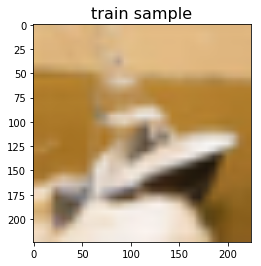

In [5]:
print(X_train_all.shape, Y_train_all.shape)
sample_id = 8
sample_x = X_train_all[sample_id]
print(X_train_all[sample_id].shape)
print(int2lable[np.argmax(Y_train_all[sample_id], axis=0)])
plt.title('train sample', size=16)
plt.imshow(sample_x)
print(X_train_all.dtype)

In [6]:
### 划分验证集 ###
#打乱顺序
num_example=X_train_all.shape[0]
arr=np.arange(num_example)
np.random.shuffle(arr)
X_train_all=X_train_all[arr]
Y_train_all=Y_train_all[arr]

VALIDATION_SIZE = 1000    #验证集大小
x_val, y_val = X_train_all[:VALIDATION_SIZE], Y_train_all[:VALIDATION_SIZE]
x_train, y_train = X_train_all[VALIDATION_SIZE:], Y_train_all[VALIDATION_SIZE:]
print(x_train.shape, x_val.shape)
print(y_val[0].shape)
print(x_train[5][..., 0])

(49000, 224, 224, 3) (1000, 224, 224, 3)
(10,)
[[ 74  74  74 ... 187 187 187]
 [ 74  74  74 ... 187 187 187]
 [ 74  74  74 ... 187 187 187]
 ...
 [ 34  34  34 ...  59  59  59]
 [ 34  34  34 ...  59  59  59]
 [ 34  34  34 ...  59  59  59]]


In [7]:
def batch_augment(data):
    seq = iaa.Sequential([
        iaa.Crop(percent=0.01), # # 从每侧裁剪图像0到16px（随机选择）
        iaa.Fliplr(0.5), # 水平翻转图像 括号内为Probability of each image to get flipped.
        iaa.Flipud(0.5), #上下翻转
        #iaa.GaussianBlur(sigma=(0, 3.0)),  # 使用0到3.0的sigma模糊图像
        iaa.Affine(scale=(0.7, 1.3), translate_percent=0.01, rotate=iap.Normal(-20, 20)),#旋转
        iaa.Multiply(iap.Positive(iap.Normal(0.0, 0.1)) + 1.0),#明暗变化
        #iaa.AddElementwise(iap.Discretize((iap.Beta(0.5, 0.5) * 2 - 1.0) * 64))
        #iaa.AdditiveGaussianNoise(scale=(0,  0.05*255)),
        #iaa.Sharpen(alpha=0.5),
        #iaa.Scale((0.5, 1.5))
    ],random_order=True)#每个batch中的Augmenters顺序不一样
    x_batch = seq.augment_images(data)
    return x_batch

deer


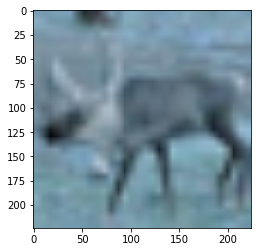

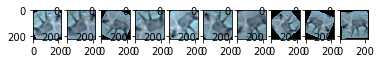

In [8]:
#展示数据扩增后的效果
imglist = []
#img = imread('data/train/3006.Bmp', as_grey=True)
sample_id = 89
sample_x = x_train[sample_id]
#img = cv2.imread('data/train/2212.Bmp', 0)
print(int2lable[np.argmax(y_train[sample_id], axis=0)])
plt.imshow(sample_x)
plt.show()
imglist.append(sample_x)
for i in range(10):
    images_aug = batch_augment(imglist)
    plt.subplot(1, 10, i+1)
    plt.imshow(images_aug[0])
plt.show()

In [9]:
### 查看预训练模型中的参数 ###
pre_model_path = 'model/vgg19/vgg19.npy'
pre_model = np.load(pre_model_path, encoding = "bytes").item()
layers = list(pre_model.keys())#将dict转换为list  层的名称
#layer_1 = pre_model[layers[0]] #第一层中内容
#layer_1_w =  pre_model[layers[0]][0]  #第一层的权重
print(layers)
layer_1_0 =  pre_model[layers[0]][1] #第一层的偏差
print(pre_model[layers[0]][0].shape) #第一层权重的形状 (3, 3, 3, 64)
print(pre_model[layers[0]][1].shape) #第一层的偏差的形状 (64,)

['conv5_4', 'conv5_1', 'fc6', 'conv5_3', 'conv5_2', 'conv4_4', 'fc7', 'conv4_1', 'conv4_2', 'conv4_3', 'fc8', 'conv3_4', 'conv3_3', 'conv3_2', 'conv3_1', 'conv1_1', 'conv1_2', 'conv2_2', 'conv2_1']
(3, 3, 512, 512)
(512,)


In [10]:
class VGG_19:
    def __init__(self, x, classname, is_training, weights=None, sess=None):
        self.parameters = []
        self.vgg_mean = [103.939, 116.779, 123.68]
        self.build_model(x, classname, is_training)
        self.skip = ['fc7', 'fc8'] #需要重新训练的层
        self.probs = self.fc8
        if weights is not None and sess is not None:
            self.load_weights(weights, sess)
    
    def maxpool(self,name,input_data, trainable):
        out = tf.nn.max_pool(input_data,[1,2,2,1],[1,2,2,1],padding="SAME",name=name)
        return out
    
    def conv(self,name, input_data, out_channel, trainable):
        in_channel = input_data.get_shape()[-1]
        with tf.variable_scope(name):
            kernel = tf.get_variable("weights", [3, 3, in_channel, out_channel], dtype=tf.float32,trainable=False)
            biases = tf.get_variable("biases", [out_channel], dtype=tf.float32,trainable=False)
            conv_res = tf.nn.conv2d(input_data, kernel, [1, 1, 1, 1], padding="SAME")
            res = tf.nn.bias_add(conv_res, biases)
            #norm = tf.layers.batch_normalization(res, center=True, scale=True, training=trainable)
            out = tf.nn.relu(res, name=name)
        self.parameters += [kernel, biases]
        return out
    
    def fc(self,name,input_data,out_channel, relu_flag = True,trainable = True):
        shape = input_data.get_shape().as_list()
        if len(shape) == 4:
            size = shape[-1] * shape[-2] * shape[-3]
        else:size = shape[1]
        input_data_flat = tf.reshape(input_data,[-1,size])
        with tf.variable_scope(name):
            weights = tf.get_variable(name="weights",shape=[size,out_channel],dtype=tf.float32,trainable = trainable)
            biases = tf.get_variable(name="biases",shape=[out_channel],dtype=tf.float32,trainable = trainable)
            res = tf.matmul(input_data_flat,weights)
            if relu_flag == True:
                #norm = tf.layers.batch_normalization(res, center=True, scale=True, training=trainable)
                out = tf.nn.relu(tf.nn.bias_add(res,biases))
            else:
                out = res
        self.parameters += [weights, biases]
        return out
    
    def build_model(self, x, classnum, is_training):
        # Preprocess
        # Convert RGB to BGR opencv 读取的为BGR格式，所以不用转换
        #red, green, blue = tf.split(axis=3, num_or_size_splits=3, value=self.rgb)#RGB格式
        blue,  green, red = tf.split(axis=3, num_or_size_splits=3, value=x)#张量被切为三份
        self.bgr = tf.concat(axis=3, values=[blue - self.vgg_mean[0], green - self.vgg_mean[1],red - self.vgg_mean[2]])
        
        # Block 1
        #对于每个卷积层和全连接层中，不需要训练的权重全部被设置为trainable=False
        self.conv1_1 = self.conv("conv1_1",self.bgr,64,trainable=True)
        self.conv1_2 = self.conv("conv1_2",self.conv1_1,64,trainable=True)
        self.pool1 = self.maxpool("pool1",self.conv1_2,trainable=True)
        
        # Block 2
        self.conv2_1 = self.conv("conv2_1",self.pool1,128,trainable=True)
        self.conv2_2 = self.conv("conv2_2",self.conv2_1,128,trainable=True)
        self.pool2 = self.maxpool("pool2",self.conv2_2,trainable=True)  
        
        # Block 3
        self.conv3_1 = self.conv("conv3_1",self.pool2,256,trainable=True)
        self.conv3_2 = self.conv("conv3_2",self.conv3_1,256,trainable=True)
        self.conv3_3 = self.conv("conv3_3",self.conv3_2,256,trainable=True)
        self.conv3_4 = self.conv("conv3_4",self.conv3_3,256,trainable=True)
        self.pool3 = self.maxpool("pool3",self.conv3_4,trainable=True)  
        
        # Block 4
        self.conv4_1 = self.conv("conv4_1",self.pool3,512,trainable=True)
        self.conv4_2 = self.conv("conv4_2",self.conv4_1,512,trainable=True)
        self.conv4_3 = self.conv("conv4_3",self.conv4_2,512,trainable=True)
        self.conv4_4 = self.conv("conv4_4",self.conv4_3,512,trainable=True)
        self.pool4 = self.maxpool("pool4",self.conv4_4,trainable=True)
        
        # Block 5
        self.conv5_1 = self.conv("conv5_1",self.pool4,512,trainable=True)
        self.conv5_2 = self.conv("conv5_2",self.conv5_1,512,trainable=True)
        self.conv5_3 = self.conv("conv5_3",self.conv5_2,512,trainable=True)
        self.conv5_4 = self.conv("conv5_4",self.conv5_3,512,trainable=True)
        self.pool5 = self.maxpool("pool5",self.conv5_4,trainable=True)
        
        # model modification for cifar-10
        self.fc6 = self.fc("fc6", self.pool5, 4096, relu_flag=True, trainable=True)
        if is_training == True:
            self.fc6 = tf.layers.dropout(self.fc6, 0.5)
        self.fc7 = self.fc("fc7", self.fc6, 4096, relu_flag=True, trainable=True)
        if is_training == True:
            self.fc7 = tf.layers.dropout(self.fc7, 0.5)
        self.fc8 = self.fc("fc8", self.fc7, classnum, relu_flag=False, trainable=True)
    
    def load_npz_weights(self, weight_file, sess):
        weights = np.load(weight_file)
        keys = sorted(weights.keys())
        for i, k in enumerate(keys):
            if i not in [36,37]:#最后一层不参加训练
                sess.run(self.parameters[i].assign(weights[k]))
        print("-----------Load weights done!---------------")
    def load_npy_weights(self, weight_file, sess):
        weights = np.load(weight_file, encoding = "bytes").item()
        #for layers in model
        for name in weights:
            if name not in self.skip:
                with tf.variable_scope(name, reuse = True):
                    for p in weights[name]:
                        if len(p.shape) == 1:
                            #bias 只有一维
                            sess.run(tf.get_variable('biases', trainable = True).assign(p))
                        else:
                            #weights
                            sess.run(tf.get_variable('weights', trainable = True).assign(p)) 

In [11]:
### 训练 ###
#训练参数
BATCH_SIZE = 64
EPOCHS = 500             #迭代次数
EARLY_STOP_PATIENCE = 30 #控制early stopping的参数

tf.reset_default_graph()
x_data = tf.placeholder(tf.float32, [None, 224, 224, 3])
y_data = tf.placeholder(tf.float32, [None, 10])
is_training = tf.placeholder(tf.bool)
ckpt_path = './model/vgg19_/mode.ckpt'

vgg = VGG_19(x_data, 10, is_training)
predict = vgg.probs
#fc6 = vgg.fc6
#fc7 = vgg.fc7

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predict, labels=y_data))
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):#批归一化层
    train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)
acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(predict, 1), tf.argmax(y_data, 1)), tf.float32))

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    vgg.load_npy_weights(pre_model_path, sess)
    
    best_validation_loss = 1000000.0
    current_epoch = 0
    
    epoch = EPOCHS
    batch_size = BATCH_SIZE
    train_size = len(x_train)
    train_index = list(range(train_size))
    
    for n in range(epoch):
        random.shuffle(train_index)  # 每个epoch都shuffle一下效果更好
        x_train_, y_train_ = x_train[train_index], y_train[train_index]
        #添加交叉验证
        #x_train, x_val, y_train, y_val = train_test_split(train_img, train_y, test_size=0.1, random_state=42, shuffle=True)
        for i in range(0, train_size, batch_size):
            x_batch = x_train_[i : i + batch_size]
            y_batch = y_train_[i : i + batch_size]
            _, loss_step = sess.run([train_step, loss], \
                             feed_dict={x_data:x_batch, y_data:y_batch, is_training:True})
            #数据扩充
            x_batch_aug = batch_augment(x_batch)
            _, loss_aug = sess.run([train_step, loss], \
                                   feed_dict={x_data:x_batch_aug, y_data:y_batch, is_training:True})
        if n % 1 == 0:#每隔几次检测输出
            val_index = random.sample(range(0, len(x_val)), 64)#随机抽出64测试
            x_val_batch, y_val_batch = x_val[val_index], y_val[val_index]
            #print(fc6.eval(feed_dict={x_data:x_val_batch, y_data:y_val_batch, is_training:False})[0])
            #print(fc7.eval(feed_dict={x_data:x_val_batch, y_data:y_val_batch, is_training:False})[0])
            #print(predict.eval(feed_dict={x_data:x_val_batch, y_data:y_val_batch, is_training:False})[0])
            validation_loss, accuracy = sess.run([loss, acc], feed_dict={x_data:x_val_batch, y_data:y_val_batch, is_training:False})
            #validation_loss = loss.eval(feed_dict={x_data:x_val, y_data:y_val, is_training:False})
            #accuracy = acc.eval(feed_dict={x_data:x_val, y_data:y_val, is_training:False})
            print("epoch %d train loss is %f validataion loss is %f accuracy is %f" % (n, loss_step, validation_loss, accuracy))
        if validation_loss < best_validation_loss:
            print('----  epoch %d current best_validation_loss is %f' % (n, validation_loss))
            best_validation_loss = validation_loss
            current_epoch = n
            saver.save(sess, ckpt_path)
        elif (n - current_epoch) >= EARLY_STOP_PATIENCE:
            print('early stoping')
            break  

epoch 0 train loss is 0.469870 validataion loss is 0.391370 accuracy is 0.859375
----  epoch 0 current best_validation_loss is 0.391370
epoch 1 train loss is 0.393995 validataion loss is 0.481967 accuracy is 0.875000
epoch 2 train loss is 0.387388 validataion loss is 0.381011 accuracy is 0.890625
----  epoch 2 current best_validation_loss is 0.381011
epoch 3 train loss is 0.033785 validataion loss is 0.219572 accuracy is 0.937500
----  epoch 3 current best_validation_loss is 0.219572
epoch 4 train loss is 0.265913 validataion loss is 0.540859 accuracy is 0.828125
epoch 5 train loss is 0.042432 validataion loss is 0.188386 accuracy is 0.937500
----  epoch 5 current best_validation_loss is 0.188386
epoch 6 train loss is 0.046228 validataion loss is 0.388706 accuracy is 0.906250
epoch 7 train loss is 0.154033 validataion loss is 0.513235 accuracy is 0.937500
epoch 8 train loss is 0.175748 validataion loss is 1.303798 accuracy is 0.796875
epoch 9 train loss is 0.017201 validataion loss is 

KeyboardInterrupt: 

In [12]:
### 计算混淆矩阵  ###
def list_flatten(a):
    b = []
    for each in a:
        if not isinstance(each, list):
            b.append(each)
        else:
            b.extend(list_flatten(each))
    return b  
def testModel(ckpt_path):
    tf.reset_default_graph()#mo
    x_data = tf.placeholder(tf.float32, [None, 224, 224, 3])
    y_data = tf.placeholder(tf.float32, [None, 10])
    is_training = tf.placeholder(tf.bool)
    vgg = VGG_19(x_data, 10, is_training)
    predict = vgg.probs
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(predict, 1), tf.argmax(y_data, 1)), tf.float32))
    saver = tf.train.Saver() 
    with tf.Session() as sess:
        saver.restore(sess, ckpt_path)
        
        val_size = len(x_val)
        batch_size = 128
        acc = []
        y_pred = []
        y_true = []
        for i in range(0, val_size, batch_size):
            x_val_batch = x_val[i : i + batch_size]
            y_val_batch = y_val[i : i + batch_size]
            y_hat_batch = predict.eval({x_data: x_val_batch, is_training:False})
            y_pred_batch = np.argmax(y_hat_batch, axis=1)
            y_pred.append(y_pred_batch.tolist())
            y_true_batch = np.argmax(y_val_batch, axis=1)
            y_true.append(y_true_batch.tolist())
            
            acc_batch = accuracy.eval(feed_dict={x_data:x_val_batch, y_data:y_val_batch, is_training:False})
            acc.append(acc_batch.tolist())
            
        y_true_array = np.array(list_flatten(y_true))
        y_pred_array = np.array(list_flatten(y_pred))
        cm = confusion_matrix(y_true_array, y_pred_array)
        print(cm)
        print(acc)

In [13]:
ckpt_path = './model/vgg19_/mode.ckpt'
testModel(ckpt_path)

INFO:tensorflow:Restoring parameters from ./model/vgg19_/mode.ckpt
[[ 98   3   1   1   0   0   0   0   1   0]
 [  0 103   1   1   0   0   0   0   0   2]
 [  1   0  78   1   4   2   2   0   0   0]
 [  1   0   5  67   3  12   2   1   0   0]
 [  0   0   5   2 102   4   1   3   0   1]
 [  0   0   0  12   1  80   0   2   0   0]
 [  1   0   4   6   5   1  97   0   0   0]
 [  0   0   0   1   3   3   0  81   0   0]
 [  7   0   1   1   1   0   0   0  90   3]
 [  0   1   0   0   1   0   0   0   0  90]]
[0.859375, 0.890625, 0.9296875, 0.8671875, 0.890625, 0.8515625, 0.890625, 0.9134615659713745]


In [24]:
def test_data_preprocessing(data_path, resized=True, img_rows=32, img_cols=32):
    if (os.path.exists(data_path + '/' + 'test_' + str(img_rows) +  '_' + str(img_cols) + '.npy')):
        print('data have already processed')
    else:
        ### Image preprocessing ###
        if resized == True:
            if not os.path.exists(data_path + "/testResized"):
                os.makedirs(data_path + "/testResized")
        for set_type in ['test']:
            files = natsorted(glob.glob(data_path + '/' + set_type + '/*'))
            data = np.zeros((len(files), img_rows, img_cols, 3))
            total = len(files)
            widgets = [set_type+'_file extract:', Percentage(), ' ', Bar('#')] 
            pbar = ProgressBar(widgets=widgets).start()
            for i, file_path in enumerate(files):
                pbar.update(int((i / (total - 1)) * 100))#进度条
                time.sleep(0.01)
                '''                
                img = imread(file_path)#, as_grey=True) #读入的图为[0, 1]图
                if resized == True:
                    img_resized = resize(img, (img_rows, img_cols))
                    data[i] = img_resized
                    #Save image
                    new_name = "/".join(file_path.split("/")[:-1] ) + "Resized/" + file_path.split("/")[-1]
                    imsave(new_name, img_resized)
                else:
                    data[i] = img
                '''
                #利用opencv读取图片
                img = cv2.imread(file_path) #读入彩色图
                if resized == True:
                    img_resized = cv2.resize(img, (img_rows, img_cols))#读入的[0, 255]的图
                    data[i] = img_resized
                    #Save image
                    new_name = "/".join(file_path.split("/")[:-1] ) + "Resized/" + file_path.split("/")[-1]
                    cv2.imwrite(new_name, img_resized) 
                else:
                    data[i] = img

            #Add channel/filter dimension [222, 32, 32] => [222, 1, 32, 32]
            #train_img = np.stack(train_img)[..., None]
            #data = data[:, :, :, np.newaxis]
            data = data.astype('uint8')
            #data /= 255
            np.save(data_path + '/' + set_type + '_' + str(img_rows) +  '_' + str(img_cols) + '.npy', data)
        pbar.finish()
    test_all = np.load(data_path + '/' + 'test_' + str(img_rows) +  '_' + str(img_cols) + '.npy')
    print('Finish')
    return test_all

In [ ]:
test_all = test_data_preprocessing(data_path, resized=True, img_rows=224, img_cols=224)

In [16]:
#由于测试集过大，占用内存过大，采用读取以后一张，计算一张的值
def submmit(data_path, model_ckpt_path, output_file):
    tf.reset_default_graph()#mo
    x_data = tf.placeholder(tf.float32, [None, 224, 224, 3])
    is_training = tf.placeholder(tf.bool)
    vgg = VGG_19(x_data, 10, is_training)
    predict = vgg.probs
    saver = tf.train.Saver() 
    

    with tf.Session() as sess:
        saver.restore(sess, ckpt_path)
        
        files = natsorted(glob.glob(data_path + '/test/*'))
        total = len(files)  
        f = open(output_file, 'w')
        f.write('id,label\n')
        pbar = ProgressBar().start()
        for i, file_path in enumerate(files):
            pbar.update(int((i / (total - 1)) * 100))#进度条
            time.sleep(0.01) 
            
            img = cv2.imread(file_path)
            img = cv2.resize(img, (224, 224))
            img = img[np.newaxis, :, :, :]
            y_hat = predict.eval({x_data: img, is_training:False})
            y_pred = np.argmax(y_hat, axis=1)
            f.write("".join([str(i+1), ',', int2lable[y_pred[0]], '\n'])) 
        f.close()
        pbar.finish()
    print('Finish!')

In [ ]:
output_file = "submission.csv"
submmit(data_path, ckpt_path, output_file)

INFO:tensorflow:Restoring parameters from ./model/vgg19_/mode.ckpt
